In [155]:
from sympy import Matrix, Rational
import matplotlib.pyplot as plt
import numpy as np

# TERMINOLOGY:
# - nodes: always the fixed points upon which values are set
# - points: variable coordinates typically used to interpolate on


In [156]:

#decide the name 
#the values of the nodes and the points are not insances of the class,in this way you will only need to use the methods that interpolate  


class basis:
    def __init__(self, r: int, nodal_values: list = None):
        self.r = r
        self.powers= self.generate_powers(r)
        self.powers_dx,self.powers_dy=self.generate_powers_der()
        
        self.nodes, self.n = self.generate_interp_nodes(r)
        self.plot_nodes()


        #matrices that rapresent the polynomials
        self.M ,self.M_dx,self.M_dy= self.generate_matrices()



    def plot_nodes(self):
        """
        plot the nodes used for the basis on the ref triangle
        """
        print("degree = ",self.r," , local dof = ",self.n)

        print(self.nodes)

        plt.figure()
        plt.scatter(self.nodes[:, 0], self.nodes[:, 1])
        plt.grid()
        plt.show()

    def generate_powers(self, r: int) -> list:
        """
        r: int = degree
        generates the powers of the polynomial in x and y up to order r 
        """
        return [(j, i) for i in range(0, r + 1) for j in range(0, r + 1) if i + j <= r]
    
    def generate_powers_der(self):
        """
        generate  the correct powers for the derivatives and store it 
        """
        der_x=[]
        der_y=[]

        for (i,j) in self.powers:
            if (i-1)>=0:
                der_x.append(((i-1),j))
            if (j-1)>=0:
                der_y.append((i,(j-1)))

        return der_x,der_y

    def generate_interp_nodes(self, p):
        """
        generates the nodes used for the basis functions 
        """
        n = (p + 1) * (p + 2) // 2
        nodes = [
            [Rational(j, p), Rational(i, p)]
            for i in range(0, p + 1)
            for j in range(0, p + 1)
            if i + j <= p
        ]
        return np.array(nodes), n
    


    def print_polynomial(self, sol,pairs,i) -> None:
        """singol polynomial print"""

        s='basis function number : '
        print("\033[1m" + s + "\033[0m",i+1)
        print()

        for ii,(i,j) in enumerate(pairs):
            print(sol[ii],'x^',i,'y^',j,end=' ')
        print()
        print()
        



    def generate_coefficients(self, evaluation_matrix, verbose: bool = False):
        coeff = []

        for i in range(self.n):
            b = [Rational(0) for j in range(self.n)]
            b[i] = Rational(1)
            b = Matrix(b)

            res = evaluation_matrix.solve(b)
            coeff.append(res)

            if verbose:
                self.print_polynomial(res,self.powers,i)

        return coeff


    #change this last two
    def generate_matrices(self):

        list=[]
        for ii in range(self.n):
            temp=[]
            for jj,(i,j) in enumerate(self.powers):
            # A[ii,jj]=((points[ii][0])**i )*((points[ii][1])**j)
                temp.append(((self.nodes[ii][0])**i )*((self.nodes[ii][1])**j))
            list.append(temp)

        A = Matrix(list)


        coeffs = self.generate_coefficients(A,False)

        
        coeffs_dx,coeffs_dy=self.generate_M_der(coeffs,False)

        return np.reshape(np.array(coeffs, dtype=np.float64), (self.n, self.n)),np.reshape(np.array(coeffs_dx, dtype=np.float64), (self.n, len(self.powers_dx))),np.reshape(np.array(coeffs_dy, dtype=np.float64), (self.n, len(self.powers_dy)))
    
    
    
    def generate_M_der(self, M: Matrix,verbose):
        coeff_dx=[]
        coeff_dy=[]
        for ii in range(self.n):
            temp_x=[]
            temp_y=[]
            for jj,(i,j) in enumerate(self.powers):
                if (i-1)>=0:
                    temp_x.append(Rational(i,1)*M[ii][jj])
                if (j-1)>=0:
                    temp_y.append(Rational(j,1)*M[ii][jj])
            if verbose:
                print("dx")
                self.print_polynomial(temp_x,self.powers_dx,ii)
                print("dy")
                self.print_polynomial(temp_y,self.powers_dy,ii)
                print()

            coeff_dx.append(temp_x)
            coeff_dy.append(temp_y)
        return coeff_dx,coeff_dy
    




    def eval(self,M,points,val,pairs):
        """
        generic function that interpolates a set of 2d nodes that are fixed in generic points inside the ref triangle,
        -M is the matrix with coeff of all the basis function in each row 
        -points is a np.array of size (n_points,2)
        -val is a np array of size (n_nodes,1)

        the output will be an col vecotr of size (n_points,1)
          
        """
        x=np.ones((np.shape(points)[0],len(pairs)),dtype=np.float64)

        for ii,(i,j) in enumerate(pairs):
            x[:,ii]=(points[:,0]**i)*(points[:,1]**j)
        

        res=x @ M.T @val

        return res
    


        
    def interpolate(self,points,val):
        """ points where you want to intepolate,val are the values at the fixed nodes """
        return self.eval(self.M,points,val,self.powers)
    
    def interpolate_dx(self,points,val):
        return self.eval(self.M_dx,points,val,self.powers_dx)
    
    def interpolate_dy(self,points,val):
        return self.eval(self.M_dy,points,val,self.powers_dy)


degree =  1  , local dof =  3
[[0 0]
 [1 0]
 [0 1]]


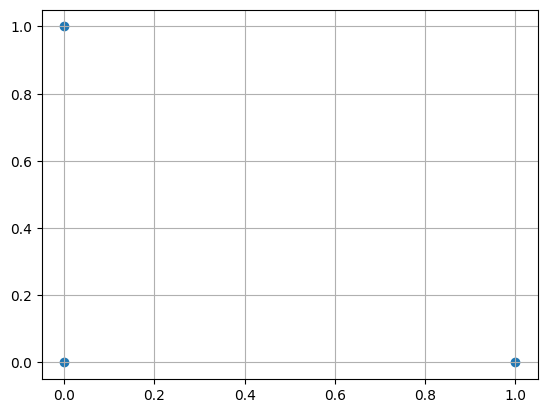

array([ 1., -1., -1.])

In [157]:
B=basis(1)
B.M[0]

In [158]:
print(B.powers)

print(B.M)

[(0, 0), (1, 0), (0, 1)]
[[ 1. -1. -1.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


In [159]:
print(B.powers_dx)
print(B.M_dx)

[(0, 0)]
[[-1.]
 [ 1.]
 [ 0.]]


In [160]:
print(B.powers_dy)
print(B.M_dy)

[(0, 0)]
[[-1.]
 [ 0.]
 [ 1.]]


In [161]:
points=np.array([[0.0, 0.0],[1.0,0.0]],dtype=np.float64)

In [162]:
val=np.array([[2.0],[1.0],[0.0]],dtype=np.float64)
print(val)

[[2.]
 [1.]
 [0.]]


In [163]:
B.interpolate(points,val)

array([[2.],
       [1.]])

In [164]:
print(B.interpolate_dx(points,val))

print(B.interpolate_dy(points,val))

[[-1.]
 [-1.]]
[[-2.]
 [-2.]]
